In [1]:
# Imports & Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

In [2]:
# Load Data
df = pd.read_csv('income.csv')
df = shuffle(df, random_state=101).reset_index(drop=True)

In [3]:
print(len(df))
df.head()

30000


,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,23,Female,HS-grad,9,Never-married,Private,Other-service,50,<=50K,0
1,37,Female,Prof-school,15,Married,State-gov,Prof-specialty,39,>50K,1
2,34,Male,Some-college,10,Divorced,Private,Adm-clerical,40,<=50K,0
3,31,Male,HS-grad,9,Married,Private,Craft-repair,40,>50K,1
4,20,Female,Some-college,10,Never-married,Private,Sales,25,<=50K,0


In [4]:
df['label'].value_counts()


0    21700
1     8300
Name: label, dtype: int64

In [5]:
# 1. Separate categorical, continuous, label
cat_cols  = ['sex','education','marital-status','workclass','occupation']
cont_cols = ['age','hours-per-week']
y_col     = ['label']

print(f'cat_cols  has {len(cat_cols)} columns')
print(f'cont_cols has {len(cont_cols)} columns')
print(f'y_col     has {len(y_col)} column')

cat_cols  has 5 columns
cont_cols has 2 columns
y_col     has 1 column


In [6]:
# Convert the 'income' column from text to numerical codes (0 and 1)
df['income'] = df['income'].astype('category').cat.codes

In [6]:
# 2. Convert to category dtype
for col in cat_cols:
    df[col] = df[col].astype('category')

In [7]:
# 3. Embedding sizes
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

In [9]:
# 4. Create an array of categorical values
cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)

cats[:5]

array([[ 0, 10,  3,  2,  6],
       [ 0, 12,  1,  4,  7],
       [ 1, 13,  0,  2,  0],
       [ 1, 10,  1,  2,  1],
       [ 0, 13,  3,  2,  9]], dtype=int8)

In [13]:
# 5. Convert categorical values to tensor (dtype int64)
cats = torch.tensor(cats, dtype=torch.int64)
cats.dtype

torch.int64

In [14]:
# 6. Stack continuous columns into a NumPy array
conts = np.stack([df[col].values for col in cont_cols], axis=1)

conts[:5]

array([[23, 50],
       [37, 39],
       [34, 40],
       [31, 40],
       [20, 25]], dtype=int64)

In [15]:
# 7. Convert continuous values to tensor (dtype float32)
conts = torch.tensor(conts, dtype=torch.float32)

conts.dtype

torch.float32

In [17]:
y = torch.tensor(df['label'].values, dtype=torch.int64).flatten()

In [18]:
# 9. Train/test split
b = 30000
t = 5000
cat_train, cat_test = cats[:b-t], cats[b-t:b]
con_train, con_test = conts[:b-t], conts[b-t:b]
y_train,   y_test   = y[:b-t],    y[b-t:b]

In [19]:
# 7. Define model
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
        layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

In [20]:
# 10. Set the random seed
torch.manual_seed(33)

In [21]:
#11. Create a TabularModel instance
model = TabularModel(emb_szs=emb_szs, n_cont=len(cont_cols), out_sz=2, layers=[50], p=0.4)
print(model)

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)


In [22]:
# 12. Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
#Train the model
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.81377232
epoch:  26  loss: 0.59307522
epoch:  51  loss: 0.51390457
epoch:  76  loss: 0.46117699
epoch: 101  loss: 0.42819440
epoch: 126  loss: 0.39755958
epoch: 151  loss: 0.38082534
epoch: 176  loss: 0.35858384
epoch: 201  loss: 0.34402204
epoch: 226  loss: 0.33575210
epoch: 251  loss: 0.32717407
epoch: 276  loss: 0.32316059
epoch: 300  loss: 0.31616521

Duration: 27 seconds


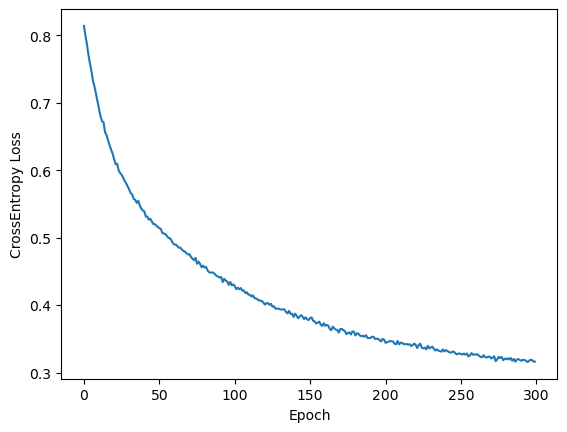

In [24]:
# 13. Plot Loss
plt.plot([l.item() for l in losses])
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.show()

In [25]:
#14. Evaluate the test set
with torch.no_grad():  
    # forward pass on the test set
    y_val = model(cat_test, con_test)

    # calculate loss against y_test
    loss = criterion(y_val, y_test)

print(f'CE Loss: {loss:.8f}')

CE Loss: 0.33355838


In [26]:
#15. Calculate the overall percent accuracy
# Get predicted class (0 or 1) from model output
preds = torch.argmax(y_val, dim=1)

# Compare predictions to true labels
correct = (preds == y_test).sum().item()
total = y_test.size(0)
accuracy = correct / total * 100

print(f"{correct} out of {total} = {accuracy:.2f}% correct")

4222 out of 5000 = 84.44% correct


In [27]:
# BONUS: Predict New Data

def predict_new(age, sex, education, marital_status, workclass, occupation, hours_per_week):
    model.eval()
    cat_dicts = {col: {cat: i for i, cat in enumerate(df[col].cat.categories)} for col in cat_cols}
    cat_input = [
        cat_dicts['sex'][sex],
        cat_dicts['education'][education],
        cat_dicts['marital-status'][marital_status],
        cat_dicts['workclass'][workclass],
        cat_dicts['occupation'][occupation]
    ]
    cont_input = [age, hours_per_week]
    cat_t = torch.tensor([cat_input], dtype=torch.int64)
    cont_t = torch.tensor([cont_input], dtype=torch.float32)
    out = model(cat_t, cont_t)
    pred = torch.argmax(out, dim=1).item()
    return pred

# Example usage
prediction = predict_new(22, "Male", "12th", "Married", "Private", "Sales", 40)
print(f"The predicted label is {prediction}")

The predicted label is 0
